# day 4-2

このノートブックの実行例は[こちら(HTML版)](lecture-gssm2025/notebooks-sample/day-4-2.html)で確認できます

---

In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import numpy as np

# 再現性のために乱数を固定する
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)

## 0. 準備

### 0.1 必要なパッケージのインストール

In [2]:
%%capture
!sudo apt-get update
!sudo apt-get install -y automake autoconf perl libtool graphviz libgraphviz-dev
!pip install -U japanize_matplotlib pyvis pygraphviz mca

教材のダウンロード

In [3]:
!git clone https://github.com/haradatm/lecture-gssm2025

Cloning into 'lecture-gssm2025'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 2), reused 12 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 355.10 KiB | 3.17 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
!ln -s lecture-gssm2025/notebooks/gssm_utils.py .

ln: failed to create symbolic link './gssm_utils.py': File exists


### 0.2 MeCab インストール (時間目安: 約3分)

In [5]:
%%time
!bash lecture-gssm2025/scripts/install_mecab.sh >> install_mecab.log 2>&1
!tail -n 1 install_mecab.log

CPU times: user 1.16 s, sys: 159 ms, total: 1.32 s
Wall time: 2min 52s


### 0.3 CaboCha インストール (時間目安: 約4分)

In [6]:
%%time
!bash lecture-gssm2025/scripts/install_cabocha.sh >> install_cabocha.log 2>&1
!tail -n 1 install_cabocha.log

CPU times: user 1.92 s, sys: 254 ms, total: 2.18 s
Wall time: 4min 38s


### 0.4 セッションの再起動

In [ ]:
import os
os.kill(os.getpid(), 9)

### 0.5 動作確認

In [1]:
import MeCab
tagger = MeCab.Tagger("-r ./tools/usr/local/etc/mecabrc")
print(tagger.parse("今日はいい天気です"))

今日	名詞,副詞可能,*,*,*,*,今日,キョウ,キョー
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
いい	形容詞,自立,*,*,形容詞・イイ,基本形,いい,イイ,イイ
天気	名詞,一般,*,*,*,*,天気,テンキ,テンキ
です	助動詞,*,*,*,特殊・デス,基本形,です,デス,デス
EOS



In [2]:
import CaboCha
cp = CaboCha.Parser("-r ./tools/usr/local/etc/cabocharc")
tree = cp.parse("今日はいい天気です")
print(tree.toString(CaboCha.FORMAT_LATTICE))

* 0 2D 0/1 -1.041733
今日	名詞,副詞可能,*,*,*,*,今日,キョウ,キョー
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 1 2D 0/0 -1.041733
いい	形容詞,自立,*,*,形容詞・イイ,基本形,いい,イイ,イイ
* 2 -1D 0/1 0.000000
天気	名詞,一般,*,*,*,*,天気,テンキ,テンキ
です	助動詞,*,*,*,特殊・デス,基本形,です,デス,デス
EOS



---

## 1. テキスト分析 (2)

### 1.0 事前準備

#### 1.0.1 定義済み関数の読み込み

以下のセルを**修正せず**に実行してください

In [3]:
import warnings
warnings.simplefilter('ignore')

import gssm_utils

%matplotlib inline

#### 1.0.1 データのダウンロード

以下のデータがダウンロード済みです

| ファイル名 | 件数 | データセット | 備考 |
| --- | --- | --- | --- |
| rakuten-1000-2024-2025.xlsx.zip | 10,000 | •レジャー+ビジネスの 10エリア<br>•エリアごと 1,000件 (ランダムサンプリング)<br>•期間: 2024/1~2025 GW明け | 本講義の全体を通して使用する |

In [4]:
# rakuten-1000-2024-2025.xlsx.zip をダウンロードする
FILE_ID = "1yKabZ7qJMRrIrP4Vtq-RrSZAqFsZriQS"
!gdown {FILE_ID}
!unzip -o rakuten-1000-2024-2025.xlsx.zip

Downloading...
From: https://drive.google.com/uc?id=1yKabZ7qJMRrIrP4Vtq-RrSZAqFsZriQS
To: /content/rakuten-1000-2024-2025.xlsx.zip
100% 2.61M/2.61M [00:00<00:00, 171MB/s]
Archive:  rakuten-1000-2024-2025.xlsx.zip
  inflating: rakuten-1000-2024-2025.xlsx  


#### 1.0.2 データの読み込み (DataFrame型)

In [5]:
import numpy as np
import pandas as pd

all_df = pd.read_excel("rakuten-1000-2024-2025.xlsx")
print(all_df.shape)
display(all_df.head())

(10000, 19)


,カテゴリー,エリア,施設番号,施設名,コメント,総合,サービス,立地,部屋,設備・アメニティ,風呂,食事,旅行の目的,同伴者,宿泊年月,投稿者,年代,性別,投稿日
0,A_レジャー,01_登別,29995,ゆとりろ洞爺湖,わんこと泊まれて良かった！,3,3,3,3,3.0,4.0,3.0,レジャー,家族,45413,投稿者,na,na,45445.668553
1,A_レジャー,01_登別,9691,登別温泉 ホテルゆもと登別,古い建物ですがきれいにしている感じでした。入った瞬間においが気になりましたが、タバコのにおい...,5,5,5,4,5.0,4.0,5.0,レジャー,家族,45474,mamemama3,40代,女性,45499.742442
2,A_レジャー,01_登別,40708,虎杖浜温泉 ホテル いずみ,3月15日に初めて宿泊させて頂きました。予約プランは和室6畳でしたが、空きがあるとのことで1...,5,5,5,5,5.0,5.0,5.0,レジャー,家族,45717,ハコ9437,40代,女性,45733.810486
3,A_レジャー,01_登別,139962,ザ レイクビュー ＴＯＹＡ 乃の風リゾート,大きめ柴犬と宿泊しましたが、部屋は充分な広さでした夕朝食のブッフェも、種類豊富で美味しかった...,4,5,5,4,4.0,4.0,5.0,レジャー,家族,45413,投稿者,na,na,45440.662477
4,A_レジャー,01_登別,168374,虎杖浜天然温泉 「旅人の湯」ホテルルートインＧｒａｎｄ室蘭,コーヒー無料サービスが嬉しい。水のペットボトルサービスがあるとさらに良い（最近デフォルトのビ...,4,3,4,4,3.0,3.0,NaN,ビジネス,一人,45505,投稿者,na,na,45529.484410


#### 1.0.3 「文書-抽出語」表 を作成する

コメント列から単語を抽出する (単語を品詞「名詞」「形容詞」「未知語」で絞り込む)

In [7]:
# 必要ライブラリのインポート
from collections import defaultdict
import MeCab

# mecab の初期化
tagger = MeCab.Tagger("-r ./tools/usr/local/etc/mecabrc --unk-feature 未知語")

# 単語頻度辞書の初期化
word_counts = defaultdict(lambda: 0)

# 抽出語情報リストの初期化
words = []

# 半角->全角変換マクロを定義する
ZEN = "".join(chr(0xff01 + i) for i in range(94))
HAN = "".join(chr(0x21 + i) for i in range(94))
HAN2ZEN = str.maketrans(HAN, ZEN)

# ストップワードを定義する
# stopwords = ['する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう', 'なる', 'ほう']
stopwords = ["湯畑"]

# データ1行ごとのループ
for index, row in all_df.iterrows():

    # 半角->全角変換した後で, mecab で解析する
    node = tagger.parseToNode(row["コメント"].translate(HAN2ZEN))

    # 形態素ごとのループ
    while node:
        # 解析結果を要素ごとにバラす
        features = node.feature.split(',')

        # 品詞1 を取り出す
        pos1 = features[0]

        # 品詞2 を取り出す
        pos2 = features[1] if len(features) > 1 else ""

        # 原形 を取り出す
        base = features[6] if len(features) > 6 else None

        # 原型がストップワードに含まれない単語のみ抽出する
        if base not in stopwords:

            # 「名詞-一般」
            if (pos1 == "名詞" and pos2 == "一般"):
                base = base if base is not None else node.surface
                postag = "名詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

            # 「形容動詞」
            elif (pos1 == "名詞" and pos2 == "形容動詞語幹"):
                base = base if base is not None else node.surface
                base = f"{base}"
                postag = "形容動詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

            # 「形容詞」
            elif pos1 == "形容詞":
                base = base if base is not None else node.surface
                postag = "形容詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

            # 「未知語」
            elif pos1 == "未知語":
                base = base if base is not None else node.surface
                postag = "未知語"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

        # 次の形態素へ
        node = node.next

# DataFrme 型に整える
columns = [
    "文書ID",
    # "単語ID",
    "表層",
    "品詞",
    "カテゴリー",
    "エリア",
    "dict_key",
]
docs_df = pd.DataFrame(words, columns=columns)

# DataFrame を表示する
print(docs_df.shape)
display(docs_df.head())

(151626, 6)


,文書ID,表層,品詞,カテゴリー,エリア,dict_key
0,1,わん,名詞,A_レジャー,01_登別,"(わん, 名詞)"
1,1,良い,形容詞,A_レジャー,01_登別,"(良い, 形容詞)"
2,2,古い,形容詞,A_レジャー,01_登別,"(古い, 形容詞)"
3,2,建物,名詞,A_レジャー,01_登別,"(建物, 名詞)"
4,2,きれい,形容動詞,A_レジャー,01_登別,"(きれい, 形容動詞)"


抽出語の出現頻度をカウントする

In [8]:
# 「文書-抽出語」 表から単語の出現回数をカウントする
word_list = []
for i, (k, v) in enumerate(sorted(word_counts.items(), key=lambda x:x[1], reverse=True)):
    word_list.append((i, k[0], v, k))

# DataFrame 型に整える
columns = [
    "単語ID",
    "表層",
    "出現頻度",
    "dict_key"
]

# DataFrame を表示する
word_counts_df = pd.DataFrame(word_list, columns=columns)
print(word_counts_df.shape)
display(word_counts_df.head(10))

(8746, 4)


,単語ID,表層,出現頻度,dict_key
0,0,部屋,6363,"(部屋, 名詞)"
1,1,良い,5242,"(良い, 形容詞)"
2,2,ホテル,2792,"(ホテル, 名詞)"
3,3,風呂,2688,"(風呂, 名詞)"
4,4,美味しい,2290,"(美味しい, 形容詞)"
5,5,ない,2176,"(ない, 形容詞)"
6,6,温泉,1836,"(温泉, 名詞)"
7,7,スタッフ,1623,"(スタッフ, 名詞)"
8,8,立地,1434,"(立地, 名詞)"
9,9,よい,1411,"(よい, 形容詞)"


### 1.1 カテゴリーやエリアごとのユーザーの注目ポイントを押さえる

#### 2.1.1 「文書-抽出語」表の作成

In [9]:
# 「単語出現回数」 表から出現回数Top 1000語のみ抽出する
word_counts_1000_df = word_counts_df[0:1000]

# 「文書-抽出語」 表も出現回数Top 150語のみに絞り込む
merged_df = pd.merge(docs_df, word_counts_1000_df, how="inner", on="dict_key", suffixes=["", "_right"])
docs_1000_df = merged_df[["文書ID", "単語ID", "表層", "品詞", "カテゴリー", "エリア", "dict_key"]]

# 「カテゴリー,エリア」でクロス集計する
cross_1000_df = pd.crosstab(
    [
        docs_1000_df['カテゴリー'],
        docs_1000_df['エリア'],
        docs_1000_df['文書ID']
    ],
    docs_1000_df['単語ID'], margins=False
)
cross_1000_df.columns = word_counts_1000_df["表層"]

# DataFrame を表示する
print(cross_1000_df.shape)
display(cross_1000_df)

(9884, 1000)


表層                  部屋  良い  ホテル  風呂  美味しい  ない  温泉  スタッフ  立地  よい  ...  鳥  寝具  \
カテゴリー  エリア   文書ID                                                ...          
A_レジャー 01_登別 1       0   1    0   0     0   0   0     0   0   0  ...  0   0   
             2       1   0    0   0     0   0   0     0   0   0  ...  0   0   
             3       1   4    1   0     0   1   1     1   0   0  ...  0   0   
             4       2   0    0   0     1   0   0     0   0   0  ...  0   0   
             5       0   1    1   0     0   0   0     0   0   0  ...  0   0   
...                 ..  ..  ...  ..   ...  ..  ..   ...  ..  ..  ... ..  ..   
B_ビジネス 10_福岡 9996    0   2    0   0     0   0   0     0   0   0  ...  0   0   
             9997    0   0    0   0     0   0   0     0   1   0  ...  0   0   
             9998    1   1    0   0     0   0   0     3   0   0  ...  0   0   
             9999    1   1    1   2     0   1   0     0   0   0  ...  0   0   
             10000   2   0    1   1     0   0   0     0   0   0  ...  0   0   

表層                  公共  年齢  大量  ファミリー  め  ｉｎ  たっぷり  幼児  
カテゴリー  エリア   文書ID                                       
A_レジャー 01_登別 1       0   0   0      0  0   0     0   0  
             2       0   0   0      0  0   0     0   0  
             3       0   0   0      0  0   0     0   0  
             4       0   0   0      0  0   0     0   0  
             5       0   0   0      0  0   0     0   0  
...                 ..  ..  ..    ... ..  ..   ...  ..  
B_ビジネス 10_福岡 9996    0   0   0      0  0   0     0   0  
             9997    0   0   0      0  0   0     0   0  
             9998    0   0   0      0  0   0     0   0  
             9999    0   0   0      0  0   0     0   0  
             10000   0   0   0      0  0   0     0   0  

[9884 rows x 1000 columns]

「文書-抽出語」表を {0,1} に変換する

In [10]:
# 「文書-抽出語」 表を {0,1} に変換する
cross_1000_df[cross_1000_df > 0] = 1

# DataFrame を表示する
print(cross_1000_df.shape)
display(cross_1000_df)

(9884, 1000)


表層                  部屋  良い  ホテル  風呂  美味しい  ない  温泉  スタッフ  立地  よい  ...  鳥  寝具  \
カテゴリー  エリア   文書ID                                                ...          
A_レジャー 01_登別 1       0   1    0   0     0   0   0     0   0   0  ...  0   0   
             2       1   0    0   0     0   0   0     0   0   0  ...  0   0   
             3       1   1    1   0     0   1   1     1   0   0  ...  0   0   
             4       1   0    0   0     1   0   0     0   0   0  ...  0   0   
             5       0   1    1   0     0   0   0     0   0   0  ...  0   0   
...                 ..  ..  ...  ..   ...  ..  ..   ...  ..  ..  ... ..  ..   
B_ビジネス 10_福岡 9996    0   1    0   0     0   0   0     0   0   0  ...  0   0   
             9997    0   0    0   0     0   0   0     0   1   0  ...  0   0   
             9998    1   1    0   0     0   0   0     1   0   0  ...  0   0   
             9999    1   1    1   1     0   1   0     0   0   0  ...  0   0   
             10000   1   0    1   1     0   0   0     0   0   0  ...  0   0   

表層                  公共  年齢  大量  ファミリー  め  ｉｎ  たっぷり  幼児  
カテゴリー  エリア   文書ID                                       
A_レジャー 01_登別 1       0   0   0      0  0   0     0   0  
             2       0   0   0      0  0   0     0   0  
             3       0   0   0      0  0   0     0   0  
             4       0   0   0      0  0   0     0   0  
             5       0   0   0      0  0   0     0   0  
...                 ..  ..  ..    ... ..  ..   ...  ..  
B_ビジネス 10_福岡 9996    0   0   0      0  0   0     0   0  
             9997    0   0   0      0  0   0     0   0  
             9998    0   0   0      0  0   0     0   0  
             9999    0   0   0      0  0   0     0   0  
             10000   0   0   0      0  0   0     0   0  

[9884 rows x 1000 columns]

#### 2.1.2 共起行列を作成する (外部変数-抽出語)

In [11]:
# 「カテゴリー」のクロス集計と「エリア」のクロス集計を連結する
aggregate_df = pd.concat(
    [
        cross_1000_df.groupby(level='カテゴリー').sum(),
        cross_1000_df.groupby(level='エリア').sum()
    ]
)

# DataFrame を表示する
print(aggregate_df.shape)
display(aggregate_df)

(12, 1000)


表層,部屋,良い,ホテル,風呂,美味しい,ない,温泉,スタッフ,立地,よい,...,鳥,寝具,公共,年齢,大量,ファミリー,め,ｉｎ,たっぷり,幼児
A_レジャー,2325,2054,753,1474,1504,890,1292,856,550,648,...,17,11,11,17,13,10,9,3,12,13
B_ビジネス,2065,1649,1243,668,519,761,108,515,844,545,...,2,5,7,1,5,9,9,8,7,6
01_登別,435,398,157,301,269,185,267,118,57,109,...,3,3,2,5,3,5,2,2,3,2
02_草津,481,441,168,362,289,197,287,193,161,141,...,2,0,1,2,3,3,4,0,0,3
03_箱根,510,450,166,287,351,188,220,195,57,142,...,2,4,4,8,3,1,1,0,4,3
04_道後,380,366,218,190,202,150,257,103,164,136,...,0,1,3,0,1,0,1,0,2,1
05_湯布院,519,399,44,334,393,170,261,247,111,120,...,10,3,1,2,3,1,1,1,3,4
06_札幌,399,324,263,118,145,142,27,102,170,105,...,0,0,2,0,1,1,0,2,2,3
07_名古屋,388,334,243,147,95,161,26,125,145,115,...,0,2,3,1,2,4,3,1,2,1
08_東京,416,333,224,133,80,155,15,99,170,96,...,0,2,0,0,1,2,3,1,0,0


#### 2.1.3 Jaccard 係数を求める (外部変数-抽出語)

In [12]:
# 抽出語の出現回数を取得する
word_counts = cross_1000_df.sum(axis=0).values

# 属性(外部変数)出現数を取得する
attr_counts = np.hstack(
    [
        all_df.value_counts('カテゴリー').values,
        all_df.value_counts('エリア').values
    ]
)

# 共起行列の中身を Jaccard 係数に入れ替える
jaccard_attrs_df = gssm_utils.jaccard_attrs_coef(aggregate_df, attr_counts, word_counts, total=10000, conditional=False)

# DataFrame を表示する
print(jaccard_attrs_df.shape)
display(jaccard_attrs_df)

(12, 1000)


表層,部屋,良い,ホテル,風呂,美味しい,ない,温泉,スタッフ,立地,よい,...,鳥,寝具,公共,年齢,大量,ファミリー,め,ｉｎ,たっぷり,幼児
A_レジャー,0.329087,0.308919,0.000000,0.260056,0.272513,0.154487,0.252937,0.155213,0.000000,0.116862,...,0.003399,0.002198,0.002197,0.003399,0.002597,0.001996,0.000000,0.000000,0.002397,0.002597
B_ビジネス,0.000000,0.000000,0.216061,0.000000,0.000000,0.000000,0.000000,0.000000,0.152072,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001599,0.000000,0.000000
01_登別,0.000000,0.092451,0.000000,0.105949,0.097676,0.075020,0.125176,0.000000,0.000000,0.000000,...,0.002953,0.002962,0.001969,0.004936,0.002956,0.004931,0.001969,0.001982,0.002953,0.001967
02_草津,0.097983,0.103473,0.000000,0.130216,0.105706,0.080277,0.135826,0.088613,0.072100,0.068713,...,0.001967,0.000000,0.000000,0.001969,0.002956,0.002953,0.003945,0.000000,0.000000,0.002953
03_箱根,0.104508,0.105808,0.000000,0.100525,0.131362,0.076330,0.100917,0.089614,0.000000,0.069235,...,0.001967,0.003953,0.003945,0.007921,0.002956,0.000000,0.000000,0.000000,0.003941,0.002953
04_道後,0.000000,0.000000,0.078474,0.000000,0.000000,0.000000,0.119925,0.000000,0.073543,0.066116,...,0.000000,0.000000,0.002956,0.000000,0.000000,0.000000,0.000000,0.000000,0.001967,0.000000
05_湯布院,0.106549,0.092704,0.000000,0.118946,0.149430,0.068521,0.122020,0.116290,0.000000,0.057887,...,0.009911,0.002962,0.000000,0.001969,0.002956,0.000000,0.000000,0.000000,0.002953,0.003941
06_札幌,0.000000,0.000000,0.096231,0.000000,0.000000,0.000000,0.000000,0.000000,0.076439,0.000000,...,0.000000,0.000000,0.001969,0.000000,0.000000,0.000000,0.000000,0.001982,0.001967,0.002953
07_名古屋,0.000000,0.000000,0.088267,0.000000,0.000000,0.000000,0.000000,0.000000,0.064473,0.000000,...,0.000000,0.001972,0.002956,0.000000,0.001969,0.003941,0.002956,0.000000,0.001967,0.000000
08_東京,0.000000,0.000000,0.080808,0.000000,0.000000,0.000000,0.000000,0.000000,0.076439,0.000000,...,0.000000,0.001972,0.000000,0.000000,0.000000,0.001967,0.002956,0.000000,0.000000,0.000000


#### 2.1.4 特徴語ランキング

In [13]:
# 「カテゴリ」や「エリア」ごとに Jaccard 係数のTop 10語を抽出する
df_list = []
for index, row in jaccard_attrs_df.iterrows():
    df_list.append(row.iloc[np.argsort(row.values)[::-1][:10]].reset_index())

# 「カテゴリ」や「エリア」ごとの Jaccard 係数のTop 10 を横方向に連結した DetaFrame を作成する
ranking_df = pd.DataFrame(pd.concat(df_list, axis=1))
ranking_df.columns = np.array([c for pair in [[x,f"jaccard"] for x in jaccard_attrs_df.index] for c in pair], dtype='object')

# DataFrame を表示する
display(ranking_df)

,A_レジャー,jaccard,B_ビジネス,jaccard,01_登別,jaccard,02_草津,jaccard,03_箱根,jaccard,...,06_札幌,jaccard,07_名古屋,jaccard,08_東京,jaccard,09_大阪,jaccard,10_福岡,jaccard
0,部屋,0.329087,ホテル,0.216061,温泉,0.125176,温泉,0.135826,露天風呂,0.137092,...,ホテル,0.096231,ホテル,0.088267,駅,0.122837,駅,0.099379,ホテル,0.095430
1,良い,0.308919,駅,0.152966,風呂,0.105949,風呂,0.130216,美味しい,0.131362,...,便利,0.083069,駅,0.070368,近い,0.082988,ホテル,0.091837,立地,0.085222
2,美味しい,0.272513,立地,0.152072,美味しい,0.097676,宿,0.111179,良い,0.105808,...,立地,0.076439,便利,0.069488,便利,0.081924,便利,0.080211,便利,0.082496
3,風呂,0.260056,便利,0.142236,良い,0.092451,美味しい,0.105706,部屋,0.104508,...,浴場,0.070343,立地,0.064473,コンビニ,0.081323,立地,0.076923,駅,0.080466
4,温泉,0.252937,近い,0.107584,夕食,0.085120,良い,0.103473,温泉,0.100917,...,駅,0.069780,フロント,0.063806,ホテル,0.080808,近い,0.074706,近い,0.065928
5,スタッフ,0.155213,フロント,0.104562,残念,0.080441,部屋,0.097983,風呂,0.100525,...,快適,0.062574,アメニティ,0.061292,立地,0.076439,コンビニ,0.068801,フロント,0.065611
6,ない,0.154487,綺麗,0.102536,種類,0.080087,スタッフ,0.088613,夕食,0.097240,...,綺麗,0.061578,綺麗,0.059421,フロント,0.061408,フロント,0.065008,快適,0.055718
7,宿,0.147732,快適,0.093102,ない,0.075020,湯,0.086039,宿,0.091182,...,広い,0.059018,快適,0.055100,アメニティ,0.056366,快適,0.062574,コンビニ,0.050904
8,露天風呂,0.144698,コンビニ,0.087271,多い,0.074556,最高,0.084148,スタッフ,0.089614,...,フロント,0.058427,近い,0.054850,快適,0.054482,広い,0.062530,アメニティ,0.050792
9,最高,0.131296,アメニティ,0.073719,露天風呂,0.073805,バス,0.080656,大変,0.085714,...,コンビニ,0.054435,コンビニ,0.047397,やすい,0.051525,綺麗,0.059421,ベッド,0.044886


ファイルに出力する

In [14]:
ranking_df.to_csv("practice-4.tsv", sep="\t")

#### 2.1.5 ワードクラウド

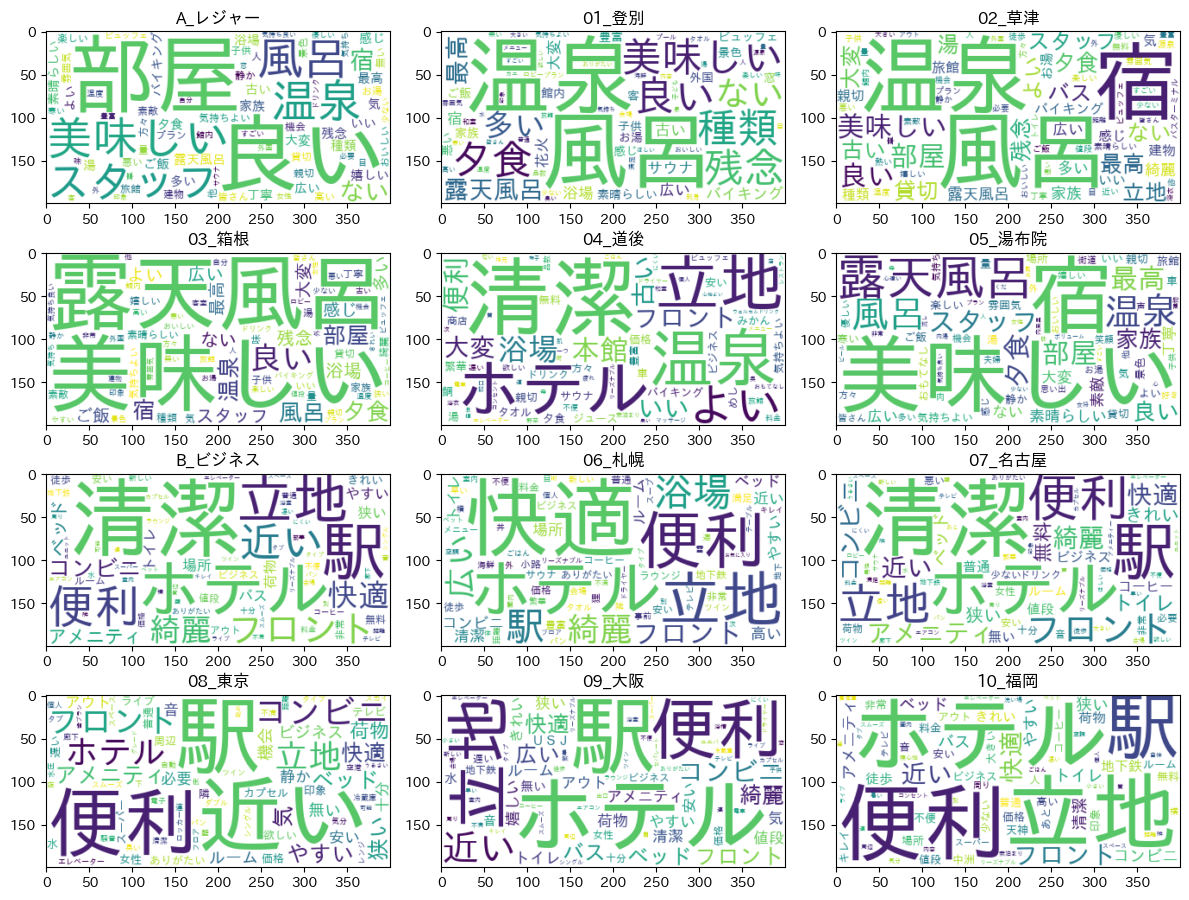

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

# サブルーチン
def sort_and_plot(name, group):

    # 「カテゴリー」ごとに Jaccard 係数でソートする
    sorted_columns = np.argsort(jaccard_attrs_df.loc[name].values)[::-1][:75]

    # Jaccard 係数Top 75語をソートして抽出する
    group_cross_df = group.iloc[:,sorted_columns]

    # プロットする
    ax = fig.add_subplot(4, 3, i+1)
    gssm_utils.plot_wordcloud_ax(ax, " ".join(group_cross_df.columns))
    ax.set_title(name)


# プロットの準備
fig = plt.figure(figsize=(12, 9))

i = 0
# カテゴリごとのループ
for name, group in cross_1000_df.groupby(level='カテゴリー'):
    # サブルーチンを呼ぶ
    sort_and_plot(name, group)
    i += 1

    # エリアごとのループ
    for sub_name, sub_group in group.groupby(level='エリア'):
        # サブルーチンを呼ぶ
        sort_and_plot(sub_name, sub_group)
        i += 1

# プロットの仕上げ
plt.tight_layout()
plt.show()

#### 2.1.6 共起ネットワーク図 (カテゴリ)

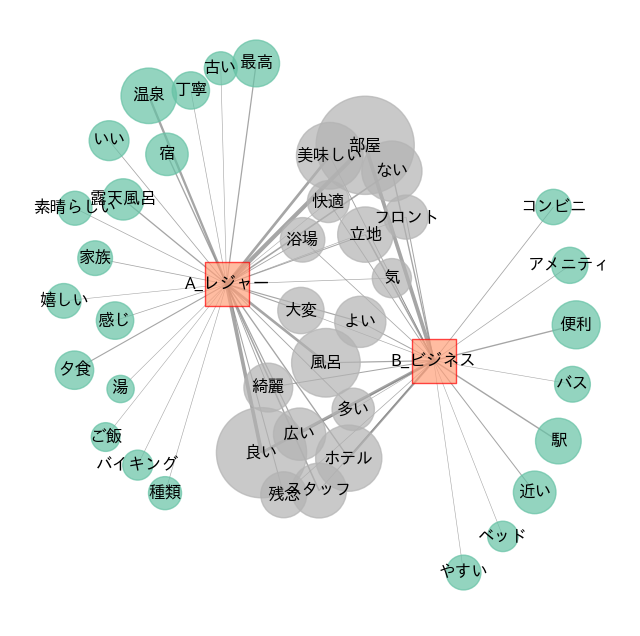

In [16]:
# 抽出語の出現回数を取得する
word_counts = cross_1000_df.sum(axis=0).values

# 属性(外部変数)出現数を取得する
attr_counts = np.hstack(
    [
        all_df.value_counts('カテゴリー').values,
    ]
)

# カテゴリのみの共起行列(共起度数)を取得する
df = aggregate_df.loc[["A_レジャー","B_ビジネス"],:]

# 共起行列(共起度数)で共起ネットワーク図を作成する
gssm_utils.plot_attrs_network(df, attr_counts, word_counts, np.sort(df.values.reshape(-1))[::-1][60], width=8, height=8)

#### 2.1.7 共起ネットワーク図 (エリア)

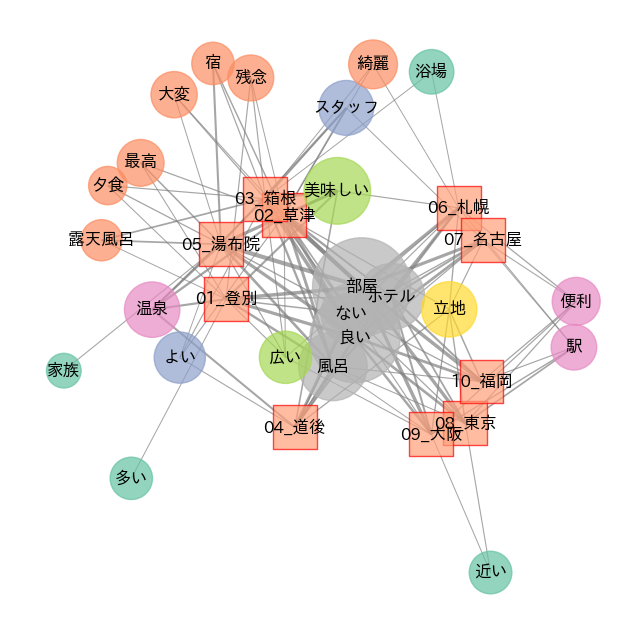

pyvis.html


In [17]:
# 抽出語の出現回数を取得する
word_counts = cross_1000_df.sum(axis=0).values

# 属性(外部変数)出現数を取得する
attr_counts = np.hstack(
    [
        all_df.value_counts('エリア').values,
    ]
)

# カテゴリのみの共起行列(共起度数)を取得する
df = aggregate_df.iloc[2:,:]

# 共起行列((共起度数)で共起ネットワーク図を作成する
gssm_utils.plot_attrs_network(df, attr_counts, word_counts, np.sort(df.values.reshape(-1))[::-1][120], width=8, height=8, pyvis=True)

#### 2.1.8 トピックを抽出する (LDA)

In [18]:
# 必要ライブラリのインポート
from sklearn.decomposition import LatentDirichletAllocation as LDA

# ライブラリ LDA によるトピック抽出
lda = LDA(max_iter=25, learning_method='batch', random_state=42, n_jobs=-1, n_components=6)
lda.fit(cross_1000_df.values)

# トピックごとに出現確率Top 20語を表示する
n_top_words = 20
feature_names = cross_1000_df.columns
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic # {topic_idx+1}:", end=" ")
    for i in topic.argsort()[:-n_top_words-1:-1]:
        print(feature_names[i], end=" ")
    print()

Topic # 1: 美味しい 種類 バイキング 良い 多い 夕食 温泉 ビュッフェ 豊富 ドリンク 残念 風呂 部屋 品数 ない おいしい 嬉しい 無料 メニュー 最高 
Topic # 2: 温泉 良い 美味しい 宿 部屋 風呂 スタッフ 露天風呂 最高 家族 大変 素晴らしい 夕食 湯 素敵 気持ちよい 丁寧 旅館 貸切 子供 
Topic # 3: ホテル フロント スタッフ 良い ない 部屋 丁寧 女性 外国 アウト 多い ビジネス 感じ 親切 無い いい アメニティ 印象 高い 方々 
Topic # 4: 便利 立地 駅 近い 良い ホテル コンビニ 部屋 徒歩 よい やすい ない 場所 綺麗 大変 バス 安い 快適 リーズナブル 価格 
Topic # 5: 部屋 広い 良い 風呂 綺麗 快適 よい 最高 浴場 立地 ホテル 清潔 きれい 美味しい ベッド やすい 大変 満足 アメニティ トイレ 
Topic # 6: 部屋 気 ない 残念 風呂 トイレ 良い 悪い バス 音 水 古い 人 ベッド タオル 狭い ホテル 無い フロント 他 


ChatGPT を使ってトピックを説明する

プロンプトの例:
> 以下はトピックとトピックごとの高確率ワードです. これを読んで各トピックの要約を日本語で作成してください.
>
> Topic # 1	フロント ホテル 浴場 部屋 親切だ 良い …

結果の例:
- トピック 1: ホテルの立地と利便性
- トピック 2: ホテルの食事とスタッフのサービス
- トピック 3: ホテルの部屋と風呂
- トピック 4: 温泉と風呂
- トピック 5: ホテルの全体的な評価
- トピック 6: 子連れ家族の滞在

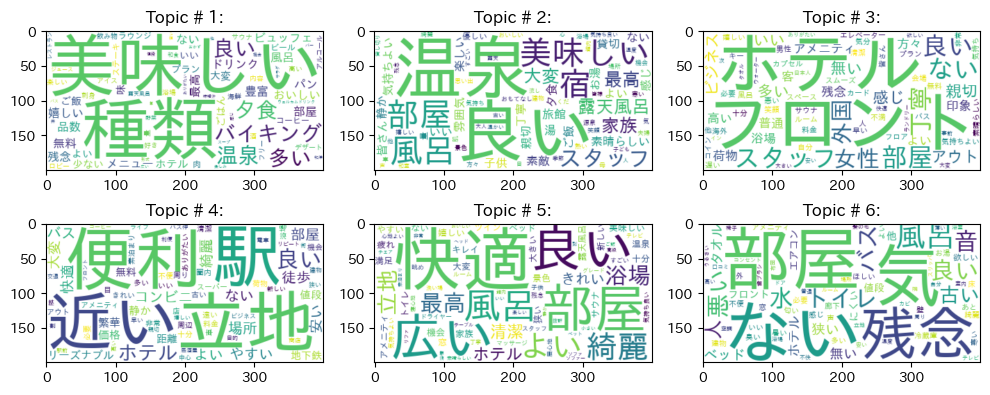

In [19]:
# トピックごとに出現確率Top 75語をプロットする
n_top_words = 75
gssm_utils.plot_topic_model(lda, feature_names, n_top_words)

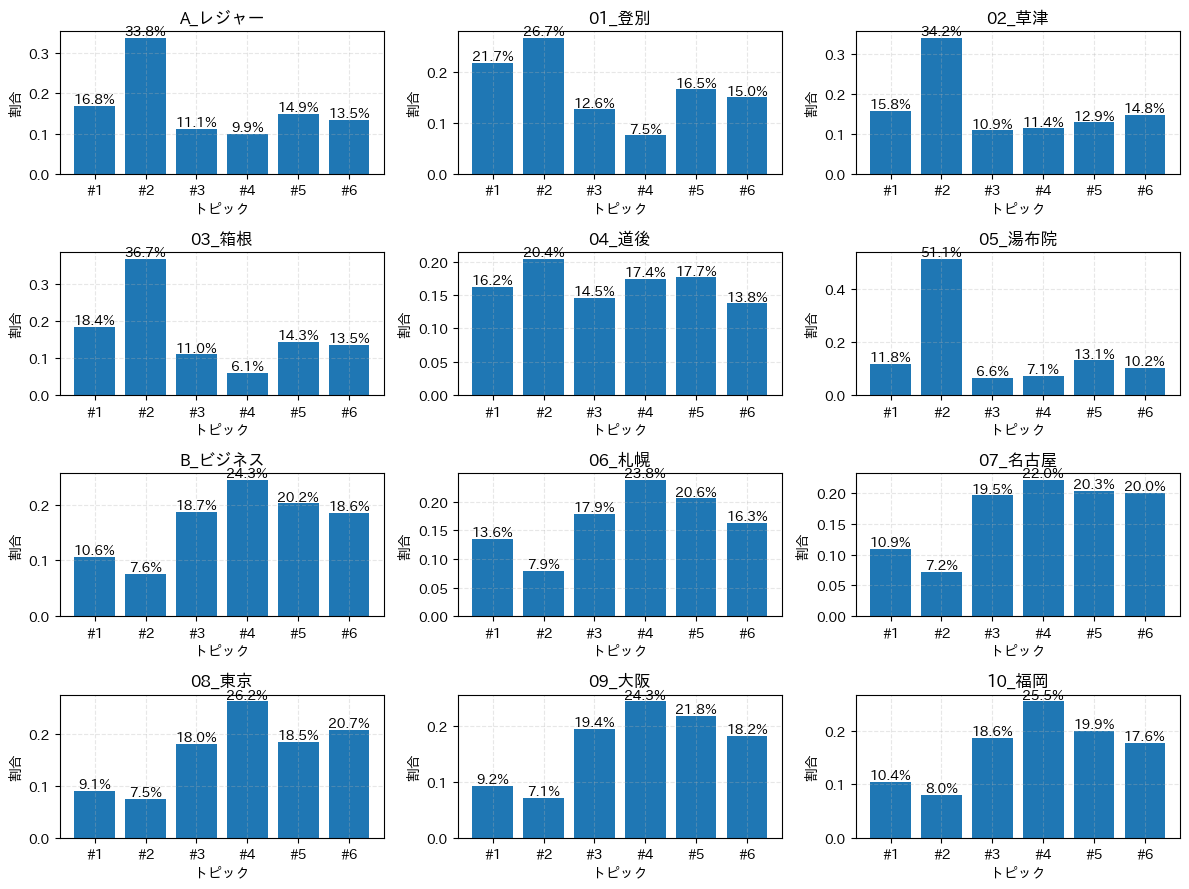

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

# サブルーチン
def sort_and_plot(name, group):

    # 文書ごとのトピック比率を取得
    doc_topic_distributions = lda.transform(group.values)

    # 文書全体のトピック比率を計算（平均を取る）
    overall_topic_distribution = np.mean(doc_topic_distributions, axis=0)

    # プロットする
    ax = fig.add_subplot(4, 3, i+1)
    gssm_utils.plot_topic_distribution_ax(ax, overall_topic_distribution)
    ax.set_title(name)

# プロットの準備
fig = plt.figure(figsize=(12, 9))

i = 0
# カテゴリごとのループ
for name, group in cross_1000_df.groupby(level='カテゴリー'):
    # サブルーチンを呼ぶ
    sort_and_plot(name, group)
    i += 1

    # エリアごとのループ
    for sub_name, sub_group in group.groupby(level='エリア'):
        # サブルーチンを呼ぶ
        sort_and_plot(sub_name, sub_group)
        i += 1

# プロットの仕上げ
plt.tight_layout()
plt.show()